Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras.layers import Flatten,Dense, Conv2D, BatchNormalization,Dropout,MaxPool2D,RandomFlip, RandomRotation,RandomZoom, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:

# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

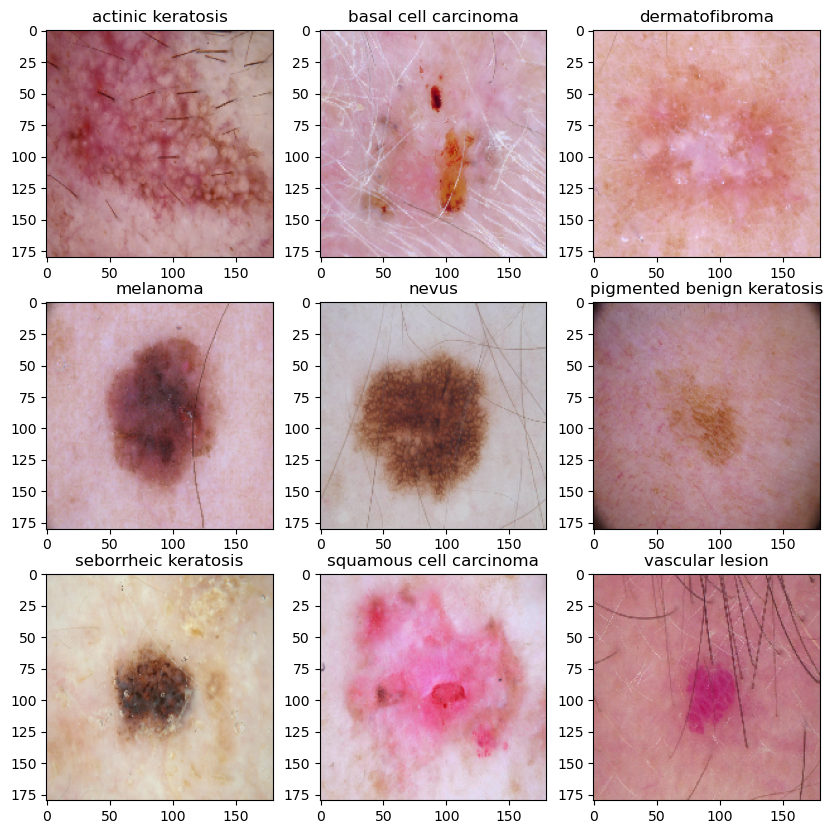

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)

    # Take the first image for the current class
    image_path = str(list(data_dir_train.glob(f"{class_names[i]}/*.jpg"))[0])

    # Load and resize the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))

    # Convert the image to a numpy array
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

    # Display the image
    plt.imshow(img_array)


    plt.title(class_names[i])

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [10]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense
# Define the model
model = Sequential([
    preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Rescale input images to [0, 1]
    Conv2D(16, (3,3), activation='relu',padding='same'), # First convolutional layer with 16 filters and relu activation function
    
    MaxPooling2D((2,2)),# Max pooling layer to downsample feature maps
    Conv2D(32, (3,3), activation='relu',padding='same'), # Second convolutional layer with 32 filters and relu activation function
    
    MaxPooling2D((2,2)),# Max pooling layer to downsample feature maps
    Conv2D(64, (3,3), activation='relu',padding='same'),# Third convolutional layer with 64 filters and relu activation function
    
    MaxPooling2D((2,2)),# Max pooling layer to downsample feature maps
    Flatten(),# Flatten layer to convert 2D feature maps into a 1D feature vector
    Dense(128, activation='relu'),# Dense (fully connected) layer with 128 neurons and relu activation function
    Dense(9, activation='softmax') # Output layer with 9 neurons (one for each class) and softmax activation function
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [11]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam', # Adam optimizer for training
              loss='sparse_categorical_crossentropy',# Sparse categorical cross-entropy loss function for multi-class classification
              metrics=['accuracy'])# Accuracy metric to monitor during training

In [12]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [13]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 [==============================] - 21s 219ms/step - loss: 2.0520 - accuracy: 0.2188 - val_loss: 1.9037 - val_accuracy: 0.3378
Epoch 2/20
56/56 [==============================] - 10s 175ms/step - loss: 1.6955 - accuracy: 0.4007 - val_loss: 1.5803 - val_accuracy: 0.4877
Epoch 3/20
56/56 [==============================] - 10s 176ms/step - loss: 1.4368 - accuracy: 0.4989 - val_loss: 1.4649 - val_accuracy: 0.5324
Epoch 4/20
56/56 [==============================] - 10s 176ms/step - loss: 1.3212 - accuracy: 0.5357 - val_loss: 1.3714 - val_accuracy: 0.5347
Epoch 5/20
56/56 [==============================] - 10s 172ms/step - loss: 1.2117 - accuracy: 0.5714 - val_loss: 1.3820 - val_accuracy: 0.5369
Epoch 6/20
56/56 [==============================] - 10s 174ms/step - loss: 1.1108 - accuracy: 0.6144 - val_loss: 1.5641 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 10s 175ms/step - loss: 1.0572 - accuracy: 0.6122 - val_loss: 1.5516 - val_accuracy: 0.53

### Visualizing training results

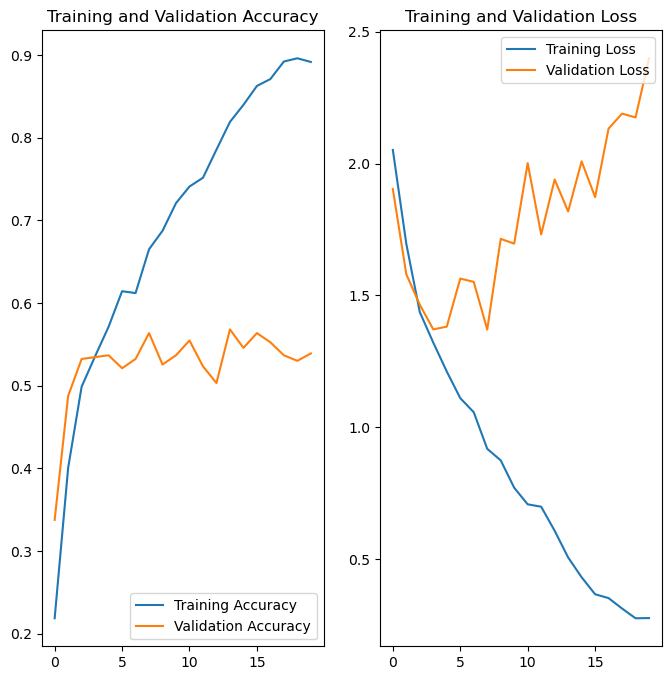

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit



## Write your findings here

#### We can see the case of overfitting here since training accuracy is too high but validation accuracy is too low.
#### We can use dropout and data augumentation strategy to test if it improves the accuracy of the model
#### Although training accuracy is 87% but there is alot of chances of wrongly classifying an image due to overfitting.

In [15]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
# Creating the ImageDataGenerator
datagen = Sequential([

    RandomFlip("horizontal_and_vertical", input_shape=(180,180,3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

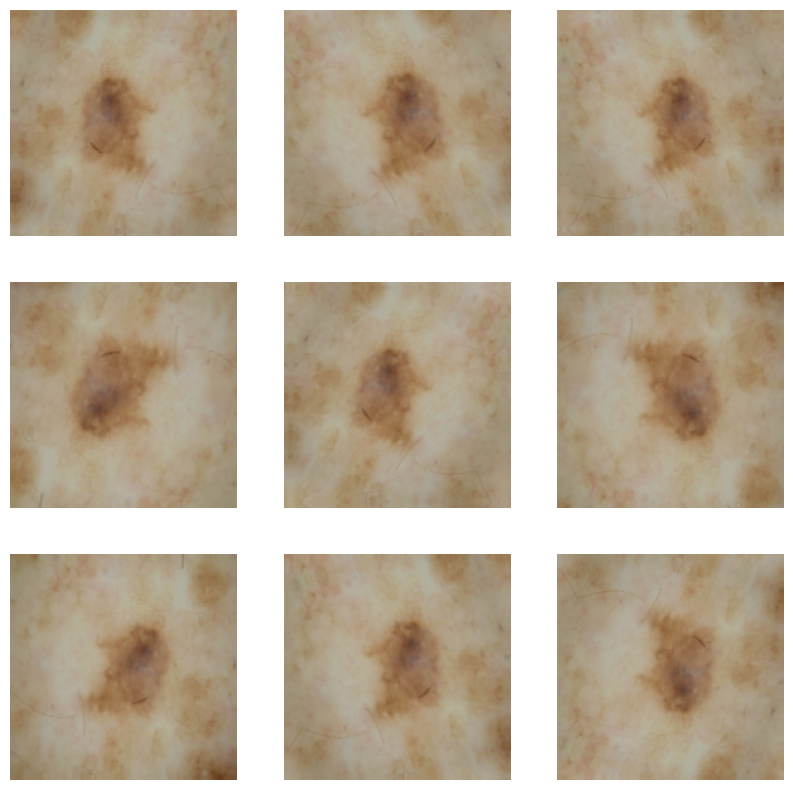

In [16]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = datagen(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [17]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
model = Sequential([

    datagen,
    preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    Conv2D(16, (3, 3), activation='relu',padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25), # Dropout layer
    Conv2D(32, (3, 3), activation='relu',padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25), # Dropout layer
    Conv2D(64, (3, 3), activation='relu',padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25), # Dropout layer
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4), # Dropout layer
    Dense(9, activation='softmax')
])

### Compiling the model

In [18]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [19]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 19s 322ms/step - loss: 2.4226 - accuracy: 0.1680 - val_loss: 2.1072 - val_accuracy: 0.1946
Epoch 2/20
56/56 [==============================] - 17s 305ms/step - loss: 2.0548 - accuracy: 0.2093 - val_loss: 2.1170 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 17s 308ms/step - loss: 1.9959 - accuracy: 0.2377 - val_loss: 1.9818 - val_accuracy: 0.3490
Epoch 4/20
56/56 [==============================] - 17s 306ms/step - loss: 1.9319 - accuracy: 0.2801 - val_loss: 1.8911 - val_accuracy: 0.4072
Epoch 5/20
56/56 [==============================] - 17s 306ms/step - loss: 1.8091 - accuracy: 0.3560 - val_loss: 1.7197 - val_accuracy: 0.4161
Epoch 6/20
56/56 [==============================] - 17s 310ms/step - loss: 1.7346 - accuracy: 0.3722 - val_loss: 1.6292 - val_accuracy: 0.4430
Epoch 7/20
56/56 [==============================] - 16s 294ms/step - loss: 1.6430 - accuracy: 0.4163 - val_loss: 1.6673 - val_accuracy: 0.4586

### Visualizing the results

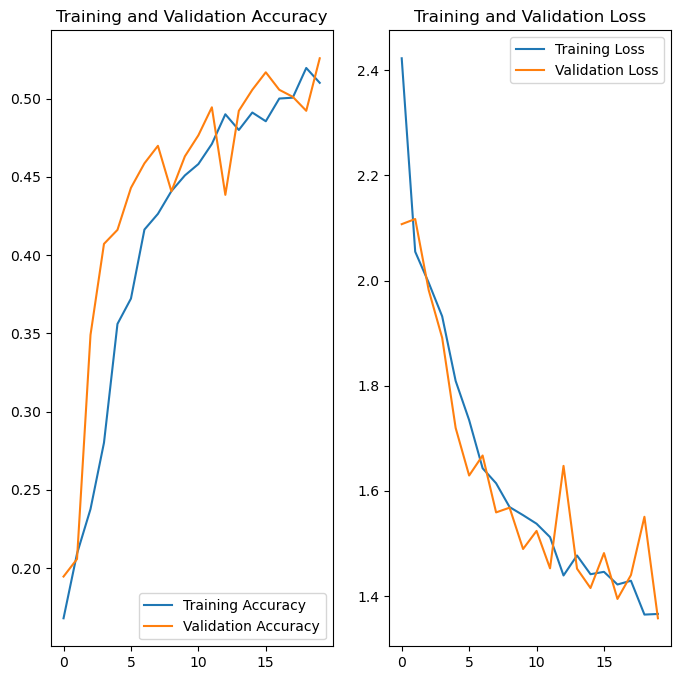

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
#### data augumentation strategy helped us improve the problem of overfitting.
#### But accuracy is decresed drastically which can cause misclassification.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [21]:
## Your code goes here.

from glob import glob
import os
# Dictionary to store the count of images for each class
class_counts = {class_name: len(glob(os.path.join(data_dir_train, class_name, '*.jpg'))) for class_name in class_names}
# Calculate the total number of samples
total_samples = sum(class_counts.values())
# Dictionary to store the percentage of samples for each class
class_percentages = {class_name: count / total_samples * 100 for class_name, count in class_counts.items()}
# Print class-wise information
for class_name in class_names:
    print(f"Class: {class_name}")
    print(f"Count: {class_counts[class_name]}")
    print(f"Percentage: {class_percentages[class_name]:.2f}%")
    print("--------------------")

print(f"Total Samples: {total_samples}")

Class: actinic keratosis
Count: 114
Percentage: 5.09%
--------------------
Class: basal cell carcinoma
Count: 376
Percentage: 16.79%
--------------------
Class: dermatofibroma
Count: 95
Percentage: 4.24%
--------------------
Class: melanoma
Count: 438
Percentage: 19.56%
--------------------
Class: nevus
Count: 357
Percentage: 15.94%
--------------------
Class: pigmented benign keratosis
Count: 462
Percentage: 20.63%
--------------------
Class: seborrheic keratosis
Count: 77
Percentage: 3.44%
--------------------
Class: squamous cell carcinoma
Count: 181
Percentage: 8.08%
--------------------
Class: vascular lesion
Count: 139
Percentage: 6.21%
--------------------
Total Samples: 2239


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
#### pigmented benign keratosis, melanoma, nevus & basal cell carcinoma


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [22]:
!pip install Augmentor

Defaulting to user installation because normal site-packages is not writeable


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [23]:
path_to_training_dataset="CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p=Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 1500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F450F99110>: 100%|██████████| 500/500 [00:05<00:00, 89.88 Samples/s]                   


Initialised with 376 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F4498C2E90>: 100%|██████████| 500/500 [00:05<00:00, 85.64 Samples/s]                   


Initialised with 95 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F46E037ED0>: 100%|██████████| 500/500 [00:06<00:00, 79.94 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1F4B69E7490>: 100%|██████████| 500/500 [00:28<00:00, 17.35 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F4B60AE150>: 100%|██████████| 500/500 [00:29<00:00, 17.21 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1F4B69EEA10>: 100%|██████████| 500/500 [00:06<00:00, 80.34 Samples/s]


Initialised with 77 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1F451319750>: 100%|██████████| 500/500 [00:13<00:00, 36.27 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F44B8623D0>: 100%|██████████| 500/500 [00:06<00:00, 82.02 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F4513C3F50>: 100%|██████████| 500/500 [00:06<00:00, 80.52 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [24]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)


4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [25]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_92c8e567-e1d0-4005-8992-88528a264257.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_f02bc8c6-24d6-40a9-bffa-140b6ead8c32.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_2493a472-4081-4571-aae9-f1916b0f7a5d.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_2f9c0253-c2a4-4d37-bbd1-5df23396ff5c.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_7ae65c4a-9d06-449d-b73d-823b89296

In [26]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [27]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [28]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [29]:
df2['Label'].value_counts() #Gives count how many new images are added

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [30]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [31]:
data_dir_train="CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [32]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [33]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
model = Sequential([    
    preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3)),    
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),    
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(), # Batch normalization layer    
    Dropout(0.25),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same'),    
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(), # Batch normalization layer
    Dropout(0.25),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(), # Batch normalization layer
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(), # Batch normalization layer
    Dropout(0.4),
    Dense(9, activation='softmax')
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [34]:
## your code goes here
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [35]:
epochs = 50
## Your code goes here, use 50 epochs.

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 73s 313ms/step - loss: 1.8687 - accuracy: 0.3785 - val_loss: 3.0616 - val_accuracy: 0.1180
Epoch 2/50
169/169 [==============================] - 46s 274ms/step - loss: 1.4347 - accuracy: 0.5006 - val_loss: 2.6131 - val_accuracy: 0.1470
Epoch 3/50
169/169 [==============================] - 47s 277ms/step - loss: 1.2230 - accuracy: 0.5530 - val_loss: 2.0742 - val_accuracy: 0.2947
Epoch 4/50
169/169 [==============================] - 46s 274ms/step - loss: 1.0995 - accuracy: 0.6016 - val_loss: 1.2096 - val_accuracy: 0.5412
Epoch 5/50
169/169 [==============================] - 48s 282ms/step - loss: 0.8681 - accuracy: 0.6947 - val_loss: 1.2943 - val_accuracy: 0.5353
Epoch 6/50
169/169 [==============================] - 47s 279ms/step - loss: 0.7032 - accuracy: 0.7506 - val_loss: 1.0081 - val_accuracy: 0.6281
Epoch 7/50
169/169 [==============================] - 48s 283ms/step - loss: 0.6113 - accuracy: 0.7839 - val_loss: 2.0985 - val_ac

#### **Todo:**  Visualize the model results

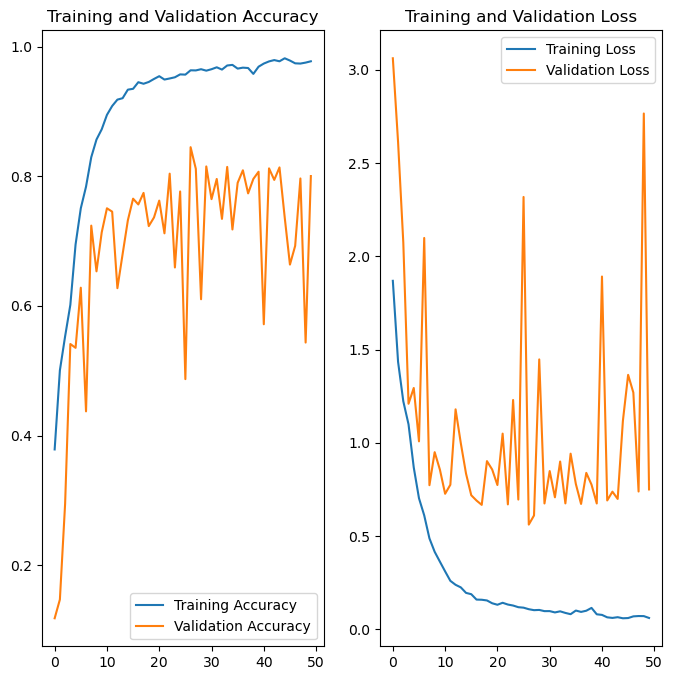

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

#### We couldn't completely get rid of overfitting but for sure Class rebalance helped us alot in acchieving better accuracy.
#### Further techniques like more layers and epochs can be used to improve the model accuracy.